<a href="https://colab.research.google.com/github/mhtasnia/DS424/blob/main/DS424_Introductory_image_preprocessing_techniques_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is image processing?**

In machine learning projects in general, you usually go through a data preprocessing or cleaning step. The goal of this step is to make your data ready for the ML model to make it easier to analyze and process computationally, as it is with images. Based on the problem you’re solving and the dataset in hand, there’s some data massaging required before you feed your images to the ML model.

Image processing could be simple tasks like image resizing.In order to feed a dataset of images to a convolutional network, they must all be the same size. Other processing tasks can take place like geometric and color transformation or converting color to grayscale and many more.

# **Why image preprocessing?**

The acquired data are usually messy and come from different sources. To feed them to the Machine Learning model (or neural network), they need to be standardized and cleaned up.


# **Data preprocessing techniques might include:**

in certain problems you’ll find it useful to lose unnecessary information from your images to reduce space or computational complexity.

For example, converting your colored images to grayscale images. This is because in many objects, color isn’t necessary to recognize and interpret an image. Grayscale can be good enough for recognizing certain objects. Because color images contain more information than black and white images, they can add unnecessary complexity and take up more space in memory (Remember how color images are represented in three channels, which means that converting it to grayscale reduces the number of pixels that need to be processed).

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform


from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import to_categorical



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models

Copying files to: /root/.keras/models
cp: cannot stat '../input/keras-pretrained-models/xception*': No such file or directory

Contents of the Keras models directory:


In [7]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d vijaykumar1799/face-mask-detection

Dataset URL: https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection
License(s): CC0-1.0
 61% 135M/222M [00:00<00:00, 1.41GB/s]
100% 222M/222M [00:00<00:00, 755MB/s] 


In [14]:
!unzip face-mask-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/with_mask/1890.png  
  inflating: Dataset/with_mask/1891.png  
  inflating: Dataset/with_mask/1892.png  
  inflating: Dataset/with_mask/1893.png  
  inflating: Dataset/with_mask/1894.png  
  inflating: Dataset/with_mask/1895.png  
  inflating: Dataset/with_mask/1896.png  
  inflating: Dataset/with_mask/1897.png  
  inflating: Dataset/with_mask/1898.png  
  inflating: Dataset/with_mask/1899.png  
  inflating: Dataset/with_mask/19.png  
  inflating: Dataset/with_mask/190.png  
  inflating: Dataset/with_mask/1900.png  
  inflating: Dataset/with_mask/1901.png  
  inflating: Dataset/with_mask/1902.png  
  inflating: Dataset/with_mask/1903.png  
  inflating: Dataset/with_mask/1904.png  
  inflating: Dataset/with_mask/1905.png  
  inflating: Dataset/with_mask/1906.png  
  inflating: Dataset/with_mask/1907.png  
  inflating: Dataset/with_mask/1908.png  
  inflating: Dataset/with_mask/1909.png  
  inflating: Dataset/with_ma

In [23]:
data_kaggle = 'Dataset'
with_mask ='Dataset/with_mask'
without_mask='Dataset/without_mask'


class_data= ['with_mask','without_mask']
len_class_data = len(class_data)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
image_count = {}
train_data = []

for i , class_data in tqdm(enumerate(class_data)):
    class_folder = os.path.join(data_kaggle,class_data)
    label = class_data
    image_count[class_data] = []

    for path in os.listdir(os.path.join(class_folder)):
        image_count[class_data].append(class_data)
        train_data.append(['{}/{}'.format(class_data, path), i, class_data])

2it [00:00, 143.58it/s]


In [26]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

with_mask -> 2994
without_mask -> 2994


In [27]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(5988, 3)

,file,id,label
0,with_mask/1685.png,0,with_mask
1,with_mask/850.png,0,with_mask
2,with_mask/1607.png,0,with_mask
3,with_mask/1936.png,0,with_mask
4,with_mask/2926.png,0,with_mask



# 1. Image Transform

This work tried to transform images from one color-space to another. The transformation you can see below:
* mask
* segment
* deskew
* gray
* thresh
* rnoise
* canny
* sharpen

According to [2] while the color image can be treated arbitrary vector value functions or collections of independent bands, it usually makes sense to think about them as highly correlated signals with strong connections to the image formation process, sensor design, and Human perception. Consider example brightening picture by adding a constant value to all three channels. In fact, adding the same value to each color channel not only increases the apparent intensity of each pixel, but it cal also affects the picture hue and saturation.



In [28]:
#masking function
def create_mask_for_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

#image  deskew function
def  deskew_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#image  gray  function
def  gray_image(image):
    mask = create_mask_for_image(image)
    output = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)
    return output/255

#image  thresh  function
def  thresh_image(image):
    img = read_img(df['file'][250],(255,255))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    output = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV) #+cv.THRESH_OTSU)
    return output


#image  rnoise  function
def  rnoise_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#image  dilate  function
def  dilate_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#image  erode  function
def  erode_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#image  opening  function
def  opening_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#image canny function
def  canny_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#image segmentation function
def segment_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp



# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_kaggle, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

SHOW SAMPLE IMAGES

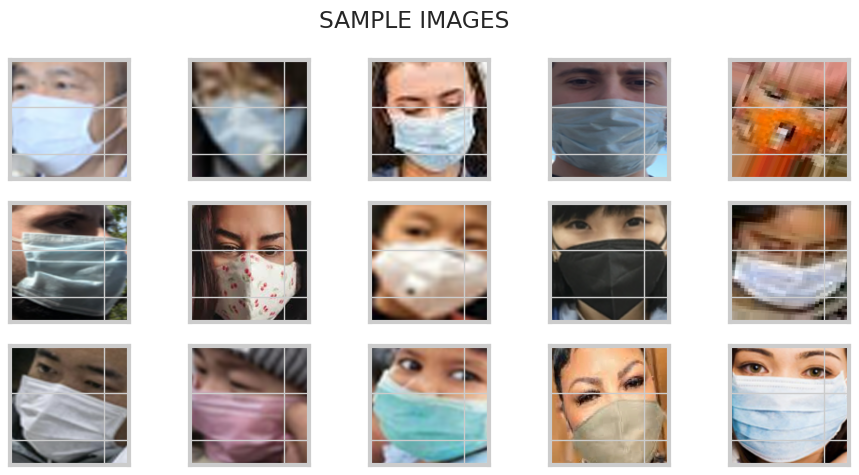

In [29]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(400)], (255,255)))/255.);
plt.show();

# Show Result

# mask

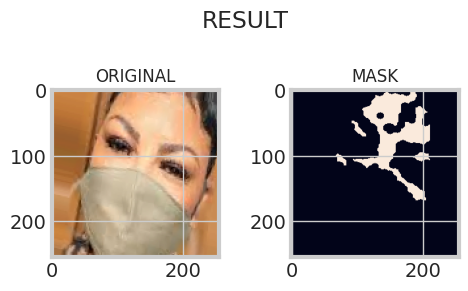

In [31]:
#get an image
img = read_img(df['file'][12],(255,255))

#mask
image_mask = create_mask_for_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('MASK', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_mask);


# segmented

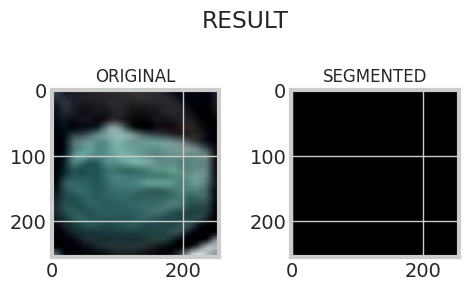

In [33]:
#get an image
img = read_img(df['file'][13],(255,255))

#segmentation
image_segmented = segment_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('SEGMENTED', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_segmented);

# deskew

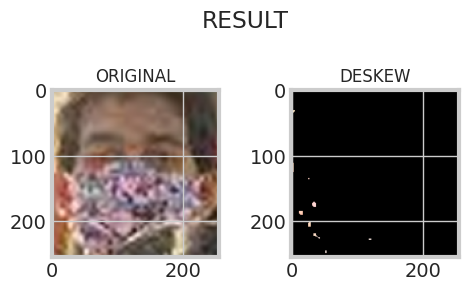

In [34]:
#get an image
img = read_img(df['file'][14],(255,255))
#deskew
image_deskew = deskew_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('DESKEW', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_deskew);

# gray

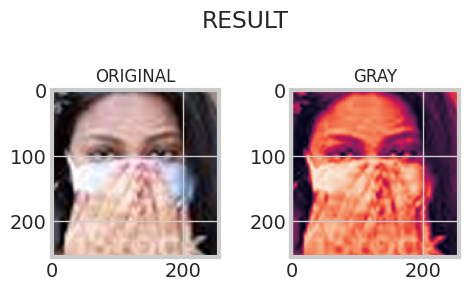

In [36]:
#get an image
img = read_img(df['file'][105],(255,255))

#gray
image_gray = gray_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('GRAY', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_gray);

# thresh

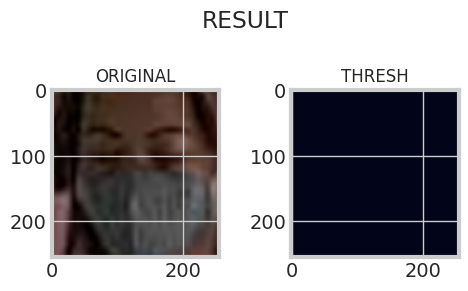

In [38]:
#get an image
img = read_img(df['file'][250],(255,255))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV) #+cv.THRESH_OTSU)
fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('THRESH', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(thresh);

# rnoise

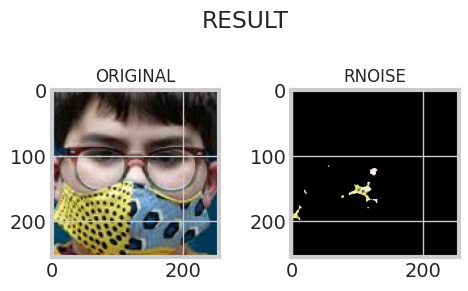

In [40]:
#get an image
img = read_img(df['file'][275],(255,255))

#rnoise
image_rnoise = rnoise_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('RNOISE', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_rnoise);

# canny

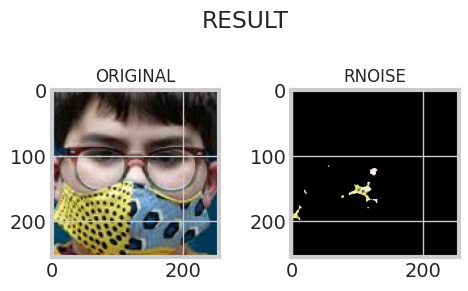

In [41]:
#get an image
img = read_img(df['file'][275],(255,255))

#rnoise
image_canny = canny_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('RNOISE', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_canny);

# sharpen

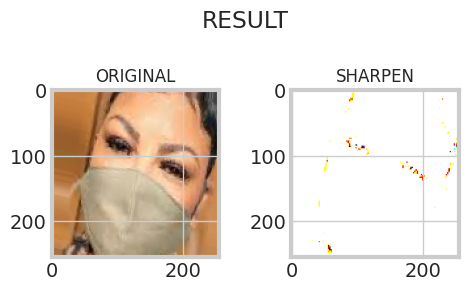

In [43]:
#get an image
img = read_img(df['file'][12],(255,255))

#sharpen the image
image_sharpen = sharpen_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('SHARPEN', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_sharpen);

# Comparison of color space transformation

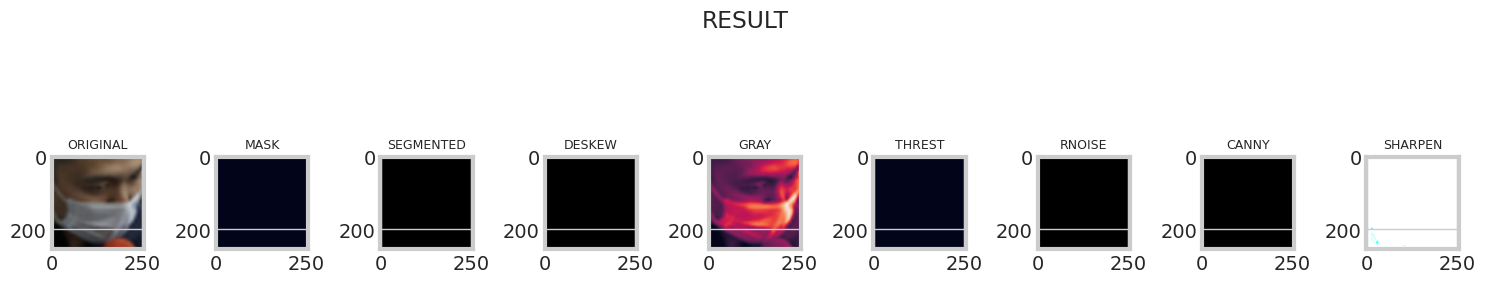

In [45]:
#get an image
img = read_img(df['file'][60],(255,255))

#mask
image_mask = create_mask_for_image(img)

#segmentation
image_segmented = segment_image(img)


#deskew
image_deskew = deskew_image(img)

#gray
image_gray = gray_image(img)

#thresh
image_thresh = thresh_image(img)

#rnoise
image_rnoise = rnoise_image(img)

#canny
image_canny = canny_image(img)

#sharpen the image
image_sharpen = sharpen_image(img)

fig, ax = plt.subplots(1, 9, figsize=(15, 6));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=9)
ax[1].set_title('MASK', fontsize=9)
ax[2].set_title('SEGMENTED', fontsize=9)
ax[3].set_title('DESKEW', fontsize=9)
ax[4].set_title('GRAY', fontsize=9)
ax[5].set_title('THREST', fontsize=9)
ax[6].set_title('RNOISE', fontsize=9)
ax[7].set_title('CANNY', fontsize=9)
ax[8].set_title('SHARPEN', fontsize=9)

ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_deskew);
ax[4].imshow(image_gray );
ax[5].imshow(thresh);
ax[6].imshow(image_rnoise);
ax[7].imshow(image_canny);
ax[8].imshow(image_sharpen);


# 2. Morphological Transformations

# erosion

The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object (Always try to keep foreground in white)

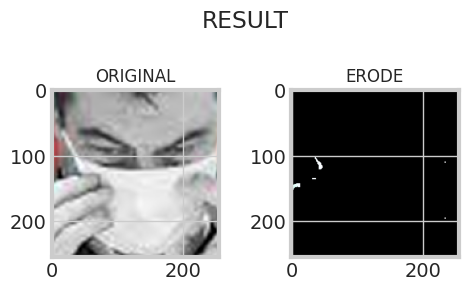

In [47]:
#get an image
img = read_img(df['file'][321],(255,255))

#erode
image_erode = erode_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('ERODE', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_erode);

# dilate

It is just opposite of erosion. Here, a pixel element is ‘1’ if atleast one pixel under the kernel is ‘1’. So it increases the white region in the image or size of foreground object increases. Normally, in cases like noise removal, erosion is followed by dilation.

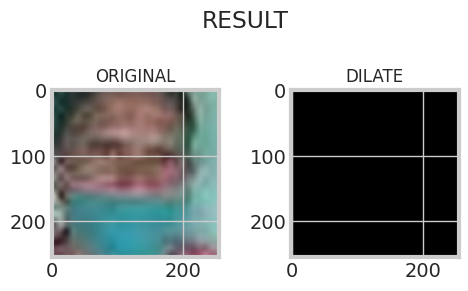

In [48]:
#get an image
img = read_img(df['file'][175],(255,255))

#dilate
image_dilate = dilate_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('DILATE', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_dilate);

# Opening

Opening is just another name of erosion followed by dilation. It is useful in removing noise

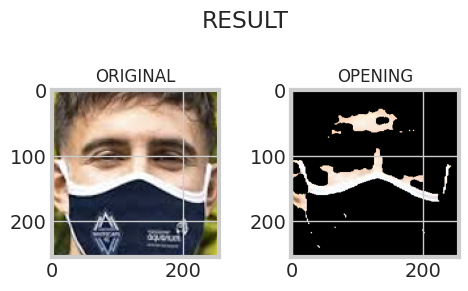

In [49]:
#get an image
img = read_img(df['file'][55],(255,255))

#opening
image_opening = opening_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('OPENING', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_opening);

# Comparison of Morphological Transformations

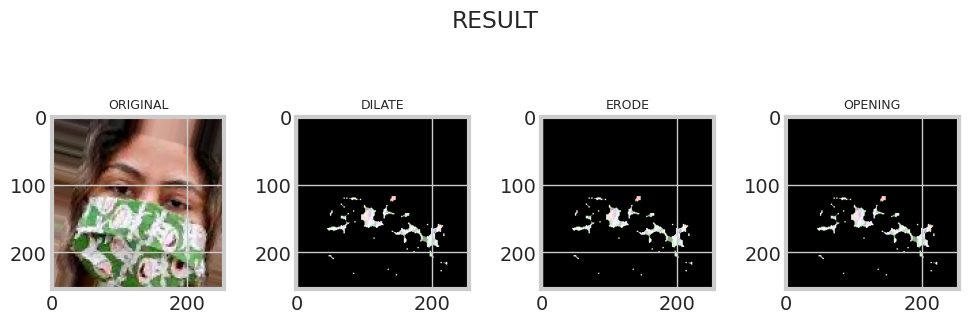

In [51]:
#get an image
img = read_img(df['file'][65],(255,255))

#dilate
image_dilate = dilate_image(img)

#erode
image_erode = erode_image(img)

#opening
image_opening = opening_image(img)

fig, ax = plt.subplots(1, 4, figsize=(10, 6));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=9)
ax[1].set_title('DILATE', fontsize=9)
ax[2].set_title('ERODE', fontsize=9)
ax[3].set_title('OPENING', fontsize=9)


ax[0].imshow(img/255);
ax[1].imshow(image_dilate);
ax[2].imshow(image_erode);
ax[3].imshow(image_opening);


# 3. Image Blurring (Image Smoothing)

Image blurring is achieved by convolving the image with a low-pass filter kernel. It is useful for removing noise. It actually removes high frequency content (e.g: noise, edges) from the image resulting in edges being blurred when this is filter is applied. (Well, there are blurring techniques which do not blur edges). OpenCV provides mainly four types of blurring techniques.

# Averaging

This is done by convolving the image with a normalized box filter. It simply takes the average of all the pixels under kernel area and replaces the central element with this average. This is done by the function cv2.blur() or cv2.boxFilter().

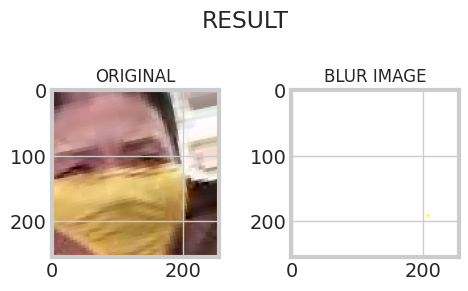

In [52]:

#get an image
img = read_img(df['file'][135],(255,255))

#Blur
blur = cv2.blur(img,(5,5))

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('BLUR IMAGE', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(blur);

# Gaussian Filtering
It is done with the function, cv2.GaussianBlur().

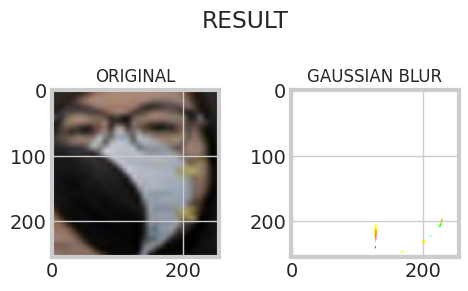

In [54]:
#get an image
img = read_img(df['file'][5],(255,255))

#GaussianBlur
Gblur = cv2.GaussianBlur(img,(5,5),0)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('GAUSSIAN BLUR', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(Gblur);

# Median Filtering

Here, the function cv2.medianBlur() computes the median of all the pixels under the kernel window and the central pixel is replaced with this median value. This is highly effective in removing salt-and-pepper noise.

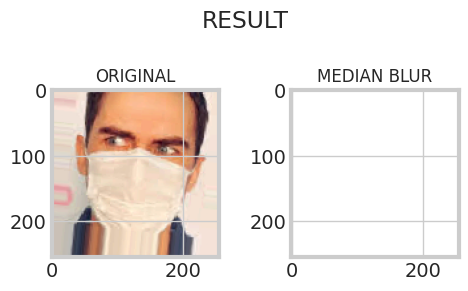

In [55]:
#get an image
img = read_img(df['file'][10],(255,255))

#medianBlur
blur_image_median = cv2.medianBlur(img,5)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('MEDIAN BLUR', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(blur_image_median);

# Bilateral Filtering

According to [3] cv2.bilateralFilter() is highly effective at noise removal while preserving edges

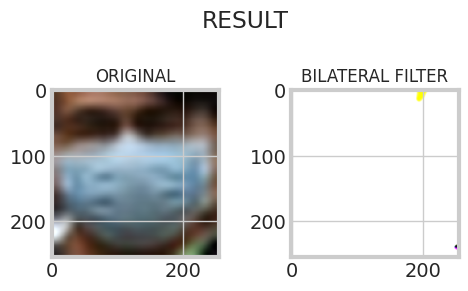

In [57]:

#get an image
img = read_img(df['file'][15],(255,255))

#BILATERAL FILTER
bilblur = cv2.bilateralFilter(img,9,75,75)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('BILATERAL FILTER', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(bilblur);


# Comparison of Image Blurring

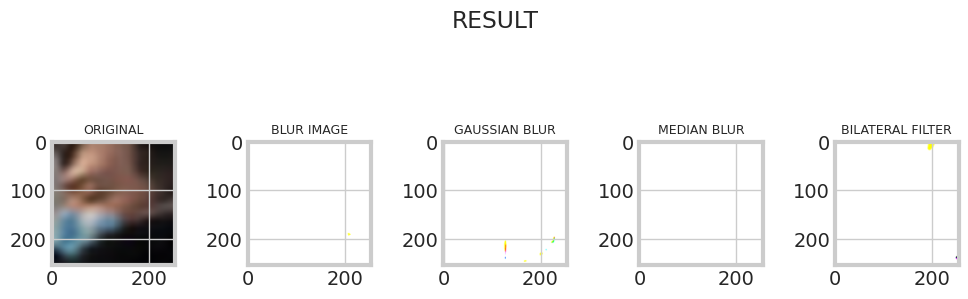

In [58]:
#get an image
img = read_img(df['file'][20],(255,255))

fig, ax = plt.subplots(1, 5, figsize=(10, 6));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIGINAL', fontsize=9)
ax[1].set_title('BLUR IMAGE', fontsize=9)
ax[2].set_title('GAUSSIAN BLUR', fontsize=9)
ax[3].set_title('MEDIAN BLUR', fontsize=9)
ax[4].set_title('BILATERAL FILTER', fontsize=9)


ax[0].imshow(img/255);
ax[1].imshow(blur);
ax[2].imshow(Gblur);
ax[3].imshow(blur_image_median);
ax[4].imshow(bilblur);


# References

[1] https://en.wikipedia.org/wiki/Computer_vision

[2] http://szeliski.org/Book/

[3] https://opencv-python-tutroals.readthedocs.io/


